In [ ]:
# Mounting data from google drive.!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/petfinder-pawpularity-score.zip > /dev/null

In [ ]:
# Importing all packages needed in the project.
import tensorflow as tf
# import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools


In [ ]:
# Let us know the version that we are going to work on!!
print('tensorflow version: ',tf.__version__)
# print('tensorflow_hub: ', hub.__version__)

tensorflow version:  2.6.0


In [ ]:
# We shall check our physical devies connected to the runtime (checking the GPU connection)..!
print('GPU availabity status :', 'Availabe' if tf.config.list_physical_devices("GPU") else 'Not available') 

GPU availabity status : Availabe


In [ ]:
train_csv = pd.read_csv("train.csv")
train_csv.head()
test_csv = pd.read_csv("test.csv")
test_csv.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [ ]:
Train_Filenames = ['/content/train/'+fname+'.jpg' for fname in train_csv.Id]
# Let's have a look at the first 10 image file names
Train_Filenames[:10]
Test_Filenames = ['/content/test/'+fname+'.jpg' for fname in test_csv.Id]
Test_Filenames[:10]

['/content/test/4128bae22183829d2b5fea10effdb0c3.jpg',
 '/content/test/43a2262d7738e3d420d453815151079e.jpg',
 '/content/test/4e429cead1848a298432a0acad014c9d.jpg',
 '/content/test/80bc3ccafcc51b66303c2c263aa38486.jpg',
 '/content/test/8f49844c382931444e68dffbe20228f4.jpg',
 '/content/test/b03f7041962238a7c9d6537e22f9b017.jpg',
 '/content/test/c978013571258ed6d4637f6e8cc9d6a3.jpg',
 '/content/test/e0de453c1bffc20c22b072b34b54e50f.jpg']

In [ ]:
# Let us make sure that the number of images in train set matches with the number of labels in labels.csv, so that we can work on accurately evaluated model
import os 
if len(os.listdir('/content/train')) == len(Train_Filenames) :
  print('The no of images in train folder are same as no of labels so we can PROCEED!!')
else :
  print('The no of images in train folder are not same as no of labels so first look into that before modelling .')

The no of images in train folder are same as no of labels so we can PROCEED!!


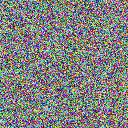

In [ ]:
# Lets view an image
from IPython.display import Image
Image('/content/test/4128bae22183829d2b5fea10effdb0c3.jpg')

## Start of 1000 images

In [ ]:
# Set number of images to use for experiments
NUM_IMAGES = 1000 #@param{type :"slider", min: 1000, max: 10000, step : 1000}

In [ ]:
X = Train_Filenames
Meta_data = train_csv.drop(labels = ['Pawpularity', 'Id'], axis = 1)
Y = train_csv['Pawpularity']
Meta_data.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,0,1,1,1,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0
3,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
# Let us now split data into train and valid using sklearn
from sklearn.model_selection import train_test_split
# Let us split the data
X_train, X_valid, Y_train, Y_valid = train_test_split(X[:NUM_IMAGES],
                                                    Y[:NUM_IMAGES],
                                                    test_size = 0.2,
                                                    random_state= 42) # Same as np.random.seed(42)

Meta_train, Meta_valid, Y_trainM, Y_validM = train_test_split(Meta_data[:NUM_IMAGES],
                                                    Y[:NUM_IMAGES],
                                                    test_size = 0.2,
                                                    random_state= 42)                                         
# Let us make sure we are working on exact dimensions of data
len(X_train), len(Y_train), len(X_valid), len(Y_valid), len(Meta_train), len(Meta_valid)
assert Y_train.all() == Y_trainM.all()
assert Y_valid.all() == Y_validM.all()
del Y_trainM
del Y_validM

In [ ]:
print(len(X_train))

800


In [ ]:
for i in Meta_data.columns:
  if Meta_data[i].any() == 0:
    print(i)

### EDA

In [ ]:
for i in Meta_train.columns:
  print(i)
  print(Meta_train[i].corr(Y_train))
print('no of meta columns', len(Meta_train.columns))

Subject Focus
-0.057926307742384255
Eyes
0.0008825692870834606
Face
0.007096701814934247
Near
0.009573249399570605
Action
0.008875077295543371
Accessory
-0.01713816820029904
Group
0.019066942101856832
Collage
0.030983688351112867
Human
-0.004416743174041199
Occlusion
0.0024823341164492032
Info
-0.050787767036055705
Blur
0.014859241562109257
no of meta columns 12


In [ ]:
# Image standard size setting up
IMAGE_SIZE = 224
# Grand Function to carry out all the preprocessing methods on images using different tensorflow methods and classes
def preprocessing(image_file) :
  '''
  The function takes image file path as input all perform some preprocessing on images like :
  1. Input image using file_path.
  2. Converts image into tensors.
  3. Normalize the tensors from 1-255 to 0-1.
  4. Resize the image into a standard and common size which is 224*224.
  5. Return processed image.
  '''
  # Step 1: access image using file path
  image = tf.io.read_file(image_file)
  # Step 2: Converting numpy from of image into tensors with 3 channels
  image = tf.image.decode_jpeg(image, channels = 3)
  # Step 3: Normalizing the image pixel values.
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Step 4: Resizing all images into a standart shape
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
  
  # Return image
  return image

In [ ]:
def meta_preprocessing(meta_data, Y):
  meta_data=tf.convert_to_tensor(meta_data)
  return meta_data, Y

In [ ]:
# # A small function to make image tensor and labels into a tuple.
# def tupler(image_file, label) :
#   '''
#   In takes the image file path and then zip the image tensor and label into a tuple.
#   '''
#   image = preprocessing(image_file)
#   return image, label

In [ ]:
# # think of need of tupler file.
# # A Grand Function to divide the data either test, train, valid into data batches.
# # Shuffling the train set only to make sure the model does not learn form sequence of the set.
# BATCH_SIZE = 32
# def create_data_batchs(X, y = None, valid_data = False, test_data = False, IsForLatent = False) :
#   '''
#   The function takes the data as input and prepares data bathcs using tensorflow based on type of set either train or test or valid.
#   '''
#   # If the data which we need to turn to batchs is test data
#   if test_data or IsForLatent:
#     print('preparing the test data into batchs')
#     # Creating the data as tensors
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
#     # Making batchs
#     data = data.map(preprocessing).batch(BATCH_SIZE)
#   # If the data which we need to turn to batchs is valid data
#   elif valid_data and not IsForLatent:
#     print('preparing the valid data into batchs')
#     # Creating the data as tesors
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
#                                               tf.constant(y)))
#     # Making batchs
#     data = data.map(tupler).batch(BATCH_SIZE)
#   # If the data which we need to turn to batchs is train data
#   elif not IsForLatent:
#     print('preparing the train data into batchs')
#     # Creating the data as tensors
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
#                                               tf.constant(y)))
#     # Shuffling the data before making them batchs is to reduce the time for it.
#     data = data.shuffle(buffer_size = len(X))
#     # Making batchs
#     data = data.map(tupler).batch(BATCH_SIZE)
#  # Lets return the data ready for experimenting
#   return data
  

In [ ]:
batch_size = 32 # Available into two other places
def create_batchs(X, Y= None, image_data = False, Meta_data = False):
  if image_data :
    print('preparing the image data into batchs for latent space')
    # Creating the data as tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    # Making batchs
    data = data.map(preprocessing).batch(batch_size)
  elif Meta_data:
    print('preparing the meta data into batchs for pawpularity')
    # Creating the data as tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(Y)))
    # Making batchs
    data = data.map(meta_preprocessing).batch(batch_size)
  return data



### Is there any need for shuffling the meta or image data like done in dog vision project.

### Is there any need to remove columns like submission type

In [ ]:
train_image_data = create_batchs(X_train, image_data = True)
valid_image_data = create_batchs(X_valid, image_data = True)
train_meta_data = create_batchs(Meta_train, Y_train, Meta_data = True)
valid_meta_data = create_batchs(Meta_valid, Y_valid, Meta_data = True)

preparing the image data into batchs for latent space
preparing the image data into batchs for latent space
preparing the meta data into batchs for pawpularity
preparing the meta data into batchs for pawpularity


In [ ]:
train_meta_data

<BatchDataset shapes: ((None, 12), (None,)), types: (tf.int64, tf.int64)>

In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''

def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + (tf.math.exp(0.5*z_logsigma)*epsilon) # TODO
  return z

In [ ]:

### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=14*14*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(14, 14, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  #latent_loss = tf.reduce_sum((tf.math.exp(logsigma))+((mu**2)-1-logsigma), axis=0)  # TODO
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.math.reduce_mean(tf.math.abs(x - x_recon), axis= (1,2,3))# TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = tf.reduce_mean((kl_weight*latent_loss)+reconstruction_loss) # TODO
  
  return vae_loss

In [ ]:
### Defining and creating the VAE ###

class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim # +1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # # classification prediction
    # y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 0:self.latent_dim] 
    z_logsigma = encoder_output[:, self.latent_dim:]

    return z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)# TODO
    
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z) # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    
    # Encode input to a prediction and latent space
    z_mean, z_logsigma = self.encode(x)
    
    # TODO: reparameterization
    z =  self.reparameterize(z_mean, z_logsigma) # TODO
    
    # TODO: reconstruction
    recon = self.decode(z) # TODO
    
    return z_mean, z_logsigma, recon

  # # Predict face or not face logit for given input x
  # def predict(self, x):
  #   y_logit, z_mean, z_logsigma = self.encode(x)
  #   return y_logit

vae = VAE(latent_dim)

In [ ]:
### Training the VAE ###

# Hyperparameters
batch_size = 32 # Available into two other places
learning_rate = 5e-4
latent_dim = 1024

# VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6 # ALL MOST IDEAL EPOCHS EXPERIENCED

# instantiate a new VAE model and optimizer
vae = VAE(latent_dim)
optimizer_vae = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def vae_training_step(x):

  with tf.GradientTape() as tape:
    # Feed input x into vae. Note that this is using the VAE call function!
    
    z_mean, z_logsigma, x_recon = vae.call(x)
    
    '''TODO: call the VAE loss function to compute the loss'''
    # loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO
    loss =  vae_loss_function(x, x_recon, z_mean, z_logsigma)
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the vae.'''
  grads = tape.gradient(loss, vae.trainable_variables) # TODO

  # apply gradients to variables
  optimizer_vae.apply_gradients(zip(grads, vae.trainable_variables))
  return loss


for i in range(num_epochs):
  for j in range(len(X_train)//batch_size): # Change the range 800 to len(train_csv) after experimenting with small data
    (train_images) = next(train_image_data.as_numpy_iterator())
    loss = vae_training_step(train_images)
  print(loss)


tf.Tensor(0.30913377, shape=(), dtype=float32)
tf.Tensor(0.21439308, shape=(), dtype=float32)
tf.Tensor(0.17616284, shape=(), dtype=float32)
tf.Tensor(0.16838518, shape=(), dtype=float32)
tf.Tensor(0.16166815, shape=(), dtype=float32)
tf.Tensor(0.16084795, shape=(), dtype=float32)


In [ ]:

# # get training faces from data loader
# all_faces = loader.get_all_train_faces()

# if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# # The training loop -- outer loop iterates over the number of epochs
# for i in range(num_epochs):

#   IPython.display.clear_output(wait=True)
#   print("Starting epoch {}/{}".format(i+1, num_epochs))

#   # Recompute data sampling proabilities
#   '''TODO: recompute the sampling probabilities for debiasing'''
#   p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO
  
#   # get a batch of training data and compute the training step
#   for j in tqdm(range(loader.get_train_size() // batch_size)):
#     # load a batch of data
#     (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
#     # loss optimization
#     loss = debiasing_train_step(x, y)
    
#     # plot the progress every 200 steps
#     if j % 500 == 0: 
#       mdl.util.plot_sample(x, y, dbvae)

In [ ]:
# (valid_images) = next(valid_image_data.as_numpy_iterator())

In [ ]:
# z_mean, z_logsigma, x_recon = vae.call(valid_images)
# loss =  vae_loss_function(valid_images, x_recon, z_mean, z_logsigma)
# print(loss)

In [ ]:
# def get_Z(images):
#   # vae_training_step(images)
#   z_mean, z_logsigma = vae.encode(images)
#   z = vae.reparameterize(z_mean, z_logsigma)
#   return z

In [ ]:
# (valid_meta, valid_labels) = next(valid_meta_data.as_numpy_iterator())
# valid_meta.shape

In [ ]:
# z_mean, z_logsigam = vae.encode(images)

In [ ]:
# z = vae.reparameterize(z_mean, z_logsigam)
# print(z.shape)

## Working for z and meta data and designing a model neural network for pawpularity

In [ ]:
# def tf_concatenator(z, meta_data, labels):
#   combined_data = tf.concat([z, meta_data], axis= 1)
#   return combined_data

In [ ]:
# print(tf_concatenator(z, valid_meta, valid_labels).shape)

In [ ]:
def Meta_model(output_dim):
  meta_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(units = 1024, activation = 'relu'),
                        tf.keras.layers.Dense(units = 512, activation = 'relu'),
                        tf.keras.layers.Dense(units = 248, activation = 'relu'),
                        tf.keras.layers.Dense(units = 100, activation = 'relu'),
                        tf.keras.layers.Dense(units = output_dim, activation= None)
  ])
  return meta_model

### do we need to have a probablistic value or a deterministic value for last dense layer

In [ ]:
# meta_model = Final_pawpularity()
# meta_model.build()

In [ ]:
# meta_model.summary()

In [ ]:
### Defining and creating the VAE ###
output_dim = 1
class PAW(tf.keras.Model):
  def __init__(self, output_dim):
    super(PAW, self).__init__()
    self.output_dim = output_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    # num_encoder_dims = 2*self.latent_dim # +1

    self.meta_model = Meta_model(output_dim)
    # self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def get_z(self, images):
    z_mean, z_logsigma = vae.encode(images)
    z = vae.reparameterize(z_mean, z_logsigma)
    return z

    # # # classification prediction
    # # y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # # latent variable distribution parameters
    # z_mean = encoder_output[:, 0:self.latent_dim] 
    # z_logsigma = encoder_output[:, self.latent_dim:]

    # return z_mean, z_logsigma

  def tf_concatenator(self, z, meta_data):
    meta_data = tf.cast(meta_data, dtype=tf.float32)
    combined_data = tf.concat([z, meta_data], axis= 1)
    return combined_data

  # # VAE reparameterization: given a mean and logsigma, sample latent variables
  # def reparameterize(self, z_mean, z_logsigma):
  #   # TODO: call the sampling function defined above
  #   z = sampling(z_mean, z_logsigma)# TODO
    
  #   return z

  # # Decode the latent space and output reconstruction
  # def decode(self, z):
  #   # TODO: use the decoder to output the reconstruction
  #   reconstruction = self.decoder(z) # TODO
  #   return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, images, meta_data): 
    
    # Encode input to a prediction and latent space
    z = self.get_z(images)
    combined_x = self.tf_concatenator(z, meta_data)
    predictions = self.meta_model(combined_x)
    return predictions
  # # Predict face or not face logit for given input x
  # def predict(self, x):
  #   y_logit, z_mean, z_logsigma = self.encode(x)
  #   return y_logit

paw = PAW(output_dim)

In [ ]:
def paw_loss_function(predictions, y_true):
  loss = tf.sqrt(tf.reduce_mean((tf.cast(y_true, dtype= tf.float32) - tf.squeeze(predictions))**2))
  return loss

In [ ]:
### Training the VAE ###

# Hyperparameters
batch_size = 32 # Available into two other places
learning_rate = 5e-4
output_dim = 1

# VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 2 # ALL MOST IDEAL EPOCHS EXPERIENCED

# instantiate a new DB-VAE model and optimizer
paw = PAW(output_dim)
optimizer_paw = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def paw_training_step(images, meta_data, y_true):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the VAE call function!
    
    predictions = paw.call(images, meta_data)
    
    '''TODO: call the VAE loss function to compute the loss'''
    # loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO
    loss =  paw_loss_function(predictions, y_true)
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, paw.trainable_variables) # TODO

  # apply gradients to variables
  optimizer_paw.apply_gradients(zip(grads, paw.trainable_variables))
  return loss


for i in range(num_epochs):
  for j in range(len(X_train)//batch_size): # Change the range 800 to len(train_csv) after experimenting with small data
    (train_metas, y_true) = next(train_meta_data.as_numpy_iterator())
    (train_images) = next(train_image_data.as_numpy_iterator())
    loss = paw_training_step(train_images, train_metas, y_true)
    print(loss)


tf.Tensor(32.005344, shape=(), dtype=float32)
tf.Tensor(30.31035, shape=(), dtype=float32)
tf.Tensor(28.619122, shape=(), dtype=float32)
tf.Tensor(26.782146, shape=(), dtype=float32)
tf.Tensor(24.668812, shape=(), dtype=float32)
tf.Tensor(22.034243, shape=(), dtype=float32)
tf.Tensor(19.251377, shape=(), dtype=float32)
tf.Tensor(16.056482, shape=(), dtype=float32)
tf.Tensor(12.8138275, shape=(), dtype=float32)
tf.Tensor(10.936364, shape=(), dtype=float32)
tf.Tensor(11.534652, shape=(), dtype=float32)
tf.Tensor(14.0390415, shape=(), dtype=float32)
tf.Tensor(13.803701, shape=(), dtype=float32)
tf.Tensor(13.881571, shape=(), dtype=float32)
tf.Tensor(13.204272, shape=(), dtype=float32)
tf.Tensor(11.317527, shape=(), dtype=float32)
tf.Tensor(9.994785, shape=(), dtype=float32)
tf.Tensor(9.693277, shape=(), dtype=float32)
tf.Tensor(10.776836, shape=(), dtype=float32)
tf.Tensor(10.677, shape=(), dtype=float32)
tf.Tensor(11.177558, shape=(), dtype=float32)
tf.Tensor(11.198285, shape=(), dtype=f

### Valid predicitions

In [ ]:
# total valid set
for i in range(len(X_valid)//batch_size):
  (valid_metas, y_true) = next(valid_meta_data.as_numpy_iterator())
  (valid_images) = next(valid_image_data.as_numpy_iterator())
  predictions = paw.call(valid_images, valid_metas)
  mse = paw_loss_function(predictions, y_true)
  print(mse)

tf.Tensor(22.186758, shape=(), dtype=float32)
tf.Tensor(22.910269, shape=(), dtype=float32)
tf.Tensor(21.320229, shape=(), dtype=float32)
tf.Tensor(22.457972, shape=(), dtype=float32)
tf.Tensor(22.306618, shape=(), dtype=float32)
tf.Tensor(22.142687, shape=(), dtype=float32)


In [ ]:
(valid_metas, y_true) = next(valid_meta_data.as_numpy_iterator())
(valid_images) = next(valid_image_data.as_numpy_iterator())
predictions = paw.call(valid_images, valid_metas)


In [ ]:
z_mean, z_logsigma, x_recon = vae.call(valid_images)
latent_loss =  vae_loss_function(valid_images, x_recon, z_mean, z_logsigma)

In [ ]:
predictions

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[29.584097],
       [33.08997 ],
       [29.871193],
       [27.881334],
       [34.458874],
       [25.146557],
       [28.595871],
       [35.072243],
       [23.034458],
       [43.79861 ],
       [29.4834  ],
       [33.94175 ],
       [27.628723],
       [27.844177],
       [31.988972],
       [29.713047],
       [34.639   ],
       [23.773382],
       [30.824936],
       [19.475529],
       [29.613195],
       [31.190502],
       [26.833183],
       [31.443487],
       [24.549286],
       [22.595127],
       [28.173126],
       [22.033741],
       [38.75439 ],
       [25.365156],
       [26.497278],
       [26.88113 ]], dtype=float32)>

In [ ]:
y_true

array([ 17,  30,  26,  72,  29,  35,  26,  71,   4,  39,  28,  26,  49,
        32, 100,  45,  59,  48,  34,  73,  49,  23,  31,  47,  26,  38,
        43,   9,  35,  29,  50,  36])

In [ ]:
mse = paw_loss_function(predictions, y_true)
mse

<tf.Tensor: shape=(), dtype=float32, numpy=21.928286>

### For test images

In [ ]:
test_image_data = create_batchs()
(test_images, test_metas) = next
(test_image_data.as_numpy_iterator())